In [47]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats

import sys
sys.path.append('/Users/jerald/Documents/Dir/Python/Stocks')
from bin.main import Manager 
m = Manager('../../')

2025-02-08 16:13:50,656 - INFO - Options DB Initialized
2025-02-08 16:13:50,656 - WARNING - You currently have 8 connections open.
2025-02-08 16:13:50,657 - INFO - Option Chain Module Initialized
2025-02-08 16:13:50,659 - INFO - PriceDB Initialized 2025-02-08 16:13:50.658979
2025-02-08 16:13:50,659 - WARNING - You have 3 open connections.
2025-02-08 16:13:50,705 - INFO - Notifications instance initialized.


In [48]:
def human_format(num, pos = 4):
    if num < 1: 
        return np.round(num, 3)   
    else:
        magnitude = 0 
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        # Add more suffix if need be. 
        return f'%.{pos}f%s'% (num, ['', 'K', 'M', 'B', 'T'][magnitude])
    
    
human_format(12223200, 0)

'12M'

We want to try to fit a distribution to an option chain. We will use the openinterest, volume, and their day to day changes to determine the best distribution to fit the data. The end goal will be to use the distribution to determine the probability that price will fall into a certain range. 

We will use the following distributions:

#### Normal Distribution:
$$
f(x; \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$
Constraints:
- $-\infty < x < \infty$
- $\sigma > 0$
- $\mu$ is the mean

#### Gamma Distribution: 

With Beta parameter (Scale): 
$$
f(x; a, b) = \frac{b^a x^{a-1} e^{-bx}}{\Gamma(a)}
$$

Constraints: 
- $x \geq 0$
- $a > 0$

> Note the scipy implementation uses a scale parameter where scale = 1/beta

In [49]:
option_chain = m.Optionsdb._parse_change_db('spy')

In [50]:
oc = option_chain.copy()
oc.head()

,stock,type,strike,expiry,gatherdate,contractsymbol,stk_price,lastprice,ask,bid,...,volga,theta,rho,lam,speed,zomma,dexp,gexp,vexp,cexp
0,SPY,Call,375.0,2025-02-07,2025-02-07 10:04:13,SPY250207C00375000,605.18,222.84,233.26,230.42,...,0.007711,-4.262177,0.007284,2.683265,-7.044603e-07,0.000166,92082.567087,13022.081340,-59.092053,182.702592
1,SPY,Call,400.0,2025-02-07,2025-02-07 10:04:13,SPY250207C00400000,605.18,203.80,208.50,205.24,...,0.009549,-4.335860,0.007755,2.927795,-9.072517e-07,0.000229,2386.738144,438.550963,-1.730598,4.735564
2,SPY,Call,410.0,2025-02-07,2025-02-07 10:04:13,SPY250207C00410000,605.18,193.21,198.89,195.77,...,0.010961,-5.471292,0.007894,3.073931,-1.104186e-06,0.000255,2375.656506,562.107117,-2.080779,4.713569
3,SPY,Call,420.0,2025-02-07,2025-02-07 10:04:13,SPY250207C00420000,605.18,180.25,188.89,185.43,...,0.011767,-5.048499,0.008097,3.295800,-1.186810e-06,0.000295,60000.860088,15045.528068,-52.447781,119.048459
4,SPY,Call,425.0,2025-02-07,2025-02-07 10:04:13,SPY250207C00425000,605.18,176.58,183.89,180.47,...,0.012321,-5.092696,0.008186,3.361698,-1.255441e-06,0.000316,4155.261005,1107.502051,-3.738936,8.244503


In [51]:
cp = oc[(oc.expiry > "2025-02-07") & (oc.strike / oc.stk_price).between(0.99, 1.01) & (oc.gatherdate == oc.gatherdate.max())]
cp_gexp = cp.pivot_table(index = 'strike', columns = 'type', values = 'gexp').reset_index(drop = False).rename_axis(None, axis = 1).fillna(0)
cp_gexp['gexp'] = cp_gexp['Call'] + cp_gexp['Put']
cp_gexp

,strike,Call,Put,gexp
0,595.0,1.537831e+07,-4.015073e+07,-2.477242e+07
1,596.0,3.805185e+06,-1.239371e+07,-8.588525e+06
2,597.0,3.666160e+06,-1.265454e+07,-8.988377e+06
3,597.5,3.139320e+06,-1.495713e+07,-1.181781e+07
4,598.0,5.793793e+06,-1.373708e+07,-7.943291e+06
5,599.0,5.916927e+06,-1.556853e+07,-9.651606e+06
6,600.0,2.548208e+07,-4.975631e+07,-2.427423e+07
7,601.0,8.208084e+06,-1.343024e+07,-5.222152e+06
8,602.0,1.059261e+07,-1.716390e+07,-6.571286e+06
9,602.5,2.054238e+05,-1.851208e+05,2.030306e+04


In [52]:
cp_temp = cp.pivot_table(index = 'strike', columns = 'type', values = 'volume').reset_index(drop = False).rename_axis(None, axis = 1).fillna(0)
cp_temp

,strike,Call,Put
0,595.0,114.000000,2696.200000
1,596.0,91.466667,1771.375000
2,597.0,124.875000,2497.437500
3,597.5,191.000000,1095.000000
4,598.0,264.937500,2388.500000
5,599.0,353.333333,2715.666667
6,600.0,1201.000000,5544.533333
7,601.0,2601.733333,4032.625000
8,602.0,5112.800000,5642.466667
9,602.5,89.000000,64.000000


In [53]:
cp_temp = cp.pivot_table(index = 'strike', columns = 'type', values = 'openinterest').reset_index(drop = False).rename_axis(None, axis = 1).fillna(0)
cp_temp

,strike,Call,Put
0,595.0,3699.733333,6869.966667
1,596.0,600.466667,1425.500000
2,597.0,602.312500,1372.437500
3,597.5,367.000000,1448.500000
4,598.0,871.062500,1587.187500
5,599.0,894.066667,1662.600000
6,600.0,6382.133333,8246.333333
7,601.0,983.133333,1186.625000
8,602.0,1262.200000,1385.466667
9,602.5,48.000000,32.000000


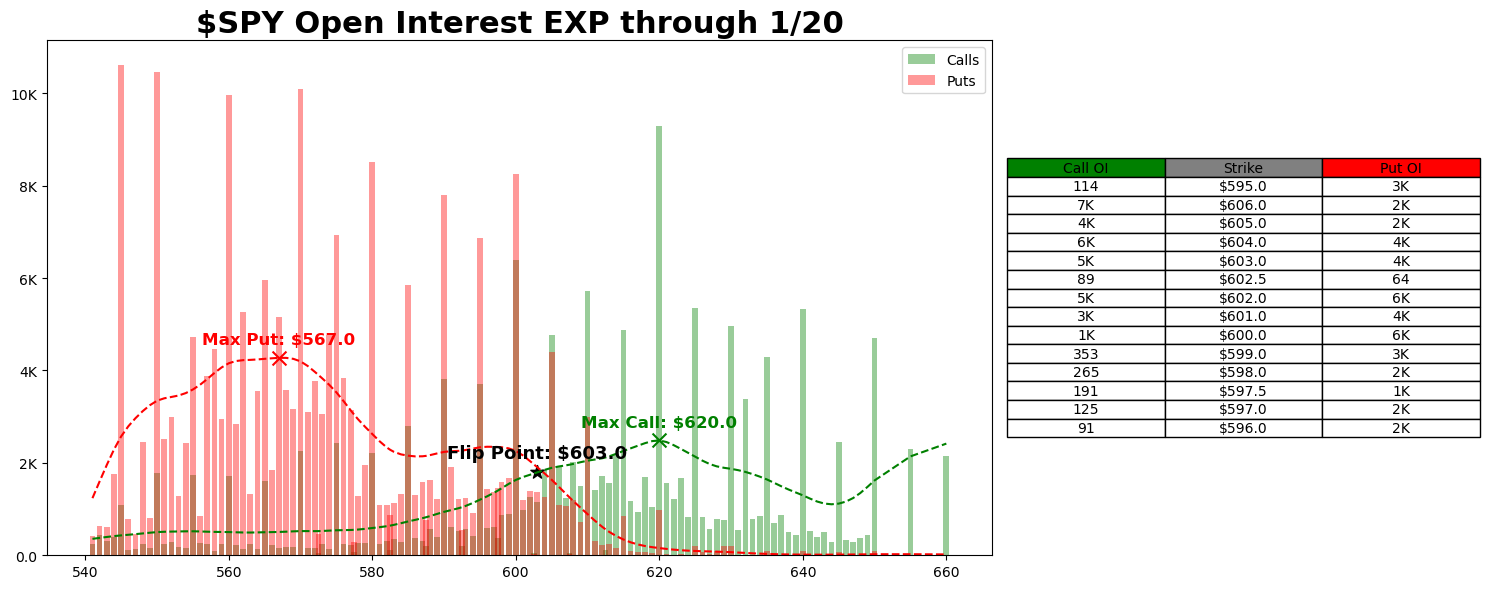

In [67]:
from curve_fitting import bspline, smoothing_spline

# Get the Volume Data with the Strikes, and two columns. 
cp = oc[(oc.expiry > "2025-02-07") & (oc.strike / oc.stk_price).between(0.90, 1.1) & (oc.gatherdate == oc.gatherdate.max())].copy()
cp_temp = cp.pivot_table(index = 'strike', columns = 'type', values = 'openinterest').reset_index(drop = False).rename_axis(None, axis = 1).fillna(0)

calls = cp_temp[['Call', 'strike']].copy().set_index('strike').sort_index()
puts = cp_temp[['Put', 'strike']].copy().set_index('strike').sort_index()

x = calls.index; y1 = calls.Call 
x2 = puts.index; y2 = puts.Put

# Fit a smoothing spline
s_x, s_y1 = smoothing_spline(x, y1)
s_x2, s_y2 = smoothing_spline(x2, y2)

# Set Up Plots 
fig, ax = plt.subplots(1,2,figsize = (15,6), width_ratios=[2, 1])

# Regular Bar Chart 
ax[0].bar(calls.index, calls.Call,label='Calls', color = 'green', alpha = 0.4)
ax[0].bar(puts.index, puts.Put, label='Puts', color = 'red', alpha = 0.4)
ax[0].legend()
# Plot the Smoothing Spline label='Calls', color = 'green', alpha = 0.4)
ax[0].plot(s_x, s_y1, label='Smoothing Spline', c = 'green', linestyle = '--')
ax[0].plot(s_x2, s_y2, label='Smoothing Spline', c = 'red', linestyle = '--')

# Id the MAX on the smoothing splines, and denote it on the plot.
max_call = s_x[np.argmax(s_y1)]; max_put = s_x2[np.argmax(s_y2)]
ax[0].scatter(max_call, np.max(s_y1), c = 'green', s = 100, marker = 'x')
ax[0].scatter(max_put, np.max(s_y2), c = 'red', s = 100, marker = 'x')

# Annotation
ax[0].annotate(
    f'Max Call: ${max_call}', 
    (max_call, np.max(s_y1)), 
    textcoords="offset points", 
    xytext=(0,10), 
    ha='center', 
    fontsize = 12, 
    fontweight = 'bold', 
    color = 'green'
    )

ax[0].annotate(
    f'Max Put: ${max_put}',
    (max_put, np.max(s_y2)),
    textcoords="offset points",
    xytext=(0,10), 
    ha='center', 
    fontsize = 12,
    fontweight = 'bold',
    color = 'red',
    )

# ID where both smoothing splines intersect
intersection = np.argwhere(np.diff(np.sign(s_y1 - s_y2))).flatten() 
ax[0].scatter(s_x[intersection][0], s_y1[intersection][0], c = 'black', s = 100, marker = '*')

# Annotate the Flip Point (the first flip)
ax[0].annotate(
    f'Flip Point: ${s_x[intersection][0]}',
    (s_x[intersection][0], s_y1[intersection][0]), 
    textcoords="offset points", 
    xytext=(0,10), 
    ha='center', 
    fontsize = 13, 
    fontweight = 'bold', 
    color = 'black'
    )

# Adjust Formats
ax[0].set_yticklabels(human_format(x, 0) for x in ax[0].get_yticks())
ax[0].set_title('$SPY Open Interest EXP through 1/20', fontsize = 22, fontweight = 'bold')

# Set Up the table to display the data, only show ATM and max 5 strikes on either side.
cp_table = oc[(oc.expiry > "2025-02-07") & (oc.strike / oc.stk_price).between(0.99, 1.01) & (oc.gatherdate == oc.gatherdate.max())].copy()
cp_tab = cp_table.pivot_table(index = 'strike', columns = 'type', values = 'volume').reset_index(drop = False).rename_axis(None, axis = 1).fillna(0)
show_df = cp_tab[['Call', 'strike', 'Put']].copy().rename(columns = {'strike':'Strike'}).sort_values('Strike')
show_df['Call'] = show_df['Call'].apply(lambda x: human_format(x, 0))
show_df['Put'] = show_df['Put'].apply(lambda x: human_format(x, 0))
show_df.Strike = show_df.Strike.astype(float)
show_df = show_df.sort_values('Strike', ascending = True)

cell_text = []
for row in range(len(show_df)):
    r = show_df.iloc[-row]
    cell_text.append((r.Call, '$' + str(r.Strike), r.Put))
    
the_table = plt.table(
    cellText = cell_text, 
    colLabels = ['Call OI', 'Strike', 'Put OI'], 
    loc = 'center', 
    cellLoc = 'center',
    colColours = ['green', 'grey', 'red'])
the_table.auto_set_font_size(False)

ax[1].axis('off')
ax[1].axis('off')

fig.tight_layout()
plt.show()

In [65]:
show_df[show_df.Strike == 595]

,Call,Strike,Put
0,114,595.0,3K


In [15]:
np.argwhere(np.diff(np.sign(s_y1 - s_y2))).flatten() 
np.sign(s_y1 - s_y2)

array([-1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [16]:
cp.columns

Index(['stock', 'type', 'strike', 'expiry', 'gatherdate', 'contractsymbol',
       'stk_price', 'lastprice', 'ask', 'bid', 'change', 'percentchange',
       'volume', 'openinterest', 'impliedvolatility', 'stk_price_chg',
       'stk_price_avg_30d', 'stk_price_avg_5d', 'lastprice_chg',
       'lastprice_avg_30d', 'lastprice_avg_5d', 'pct_chg', 'iv_chg',
       'iv_avg_5d', 'iv_avg_30d', 'iv_avg_all', 'vol_chg', 'oi_chg', 'flag',
       'amnt', 'timevalue', 'cash', 'fairvalue', 'delta', 'gamma', 'vanna',
       'charm', 'color', 'vega', 'volga', 'theta', 'rho', 'lam', 'speed',
       'zomma', 'dexp', 'gexp', 'vexp', 'cexp'],
      dtype='object')

Normal Distribution Parameters: (63443.36363636369, 98879.79471999205)
Gamma Distribution Parameters: (0.4475052128218433, 74.99999999999999, 128057.0781988966)
Exponential Distribution Parameters: (75.0, 63368.36363636369)
Log Normal Distribution Parameters: (1.670796657244575, -254.9436115962819, 20933.609057591882)


strike,541.000000,542.000000,543.000000,544.000000,545.000000,546.000000,547.000000,548.000000,549.000000,550.000000,551.000000,552.000000,553.000000,554.000000,555.000000,556.000000,557.000000,558.000000,559.000000,560.000000,561.000000,562.000000,563.000000,564.000000,565.000000,566.000000,567.000000,568.000000,569.000000,570.000000,571.000000,572.000000,572.500000,573.000000,574.000000,575.000000,576.000000,577.000000,577.500000,578.000000,579.000000,580.000000,581.000000,582.000000,582.500000,583.000000,584.000000,585.000000,586.000000,587.000000,587.500000,588.000000,589.000000,590.000000,591.000000,592.000000,592.500000,593.000000,594.000000,595.000000,596.000000,597.000000,597.500000,598.000000,599.000000,600.000000,601.000000,602.000000,602.500000,603.000000,604.000000,605.000000,606.000000,607.000000,607.500000,608.000000,609.000000,610.000000,611.000000,612.000000,612.500000,613.000000,614.000000,615.000000,616.000000,617.000000,618.000000,619.000000,620.000000,621.000000,622.000000,623.000000,624.000000,625.000000,626.000000,627.000000,628.000000,629.000000,630.000000,631.000000,632.000000,633.000000,634.000000,635.000000,636.000000,637.000000,638.000000,639.000000,640.000000,641.000000,642.000000,643.000000,644.000000,645.000000,646.000000,647.000000,648.000000,649.000000,650.000000,655.000000,660.000000
Normal,0.000003,0.000003,0.000003,0.000004,0.000000,0.000003,0.000003,0.000004,0.000003,0.000000,0.000004,0.000004,0.000004,0.000004,0.000002,0.000004,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000004,0.000001,0.000004,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000003,0.000004,0.000004,0.000000,0.000004,0.000004,0.000003,0.000004,0.000004,0.000000,0.000004,0.000004,0.000003,0.000004,0.000004,0.000001,0.000004,0.000004,0.000003,0.000004,0.000004,0.000000,0.000004,0.000004,0.000003,0.000004,0.000004,0.000000,0.000004,0.000004,0.000003,0.000004,0.000004,0.000000,0.000004,0.000004,0.000003,0.000004,0.000004,0.000000,0.000004,0.000004,0.000003,0.000004,0.000004,0.000001,0.000004,0.000004,0.000003,0.000004,0.000004,0.000002,0.000004,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000003,0.000002,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000002,0.000003,0.000003,0.000003,0.000003,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000004,0.000004
Gamma,0.000021,0.000015,0.000017,0.000010,0.000000,0.000017,0.000022,0.000009,0.000017,0.000000,0.000007,0.000006,0.000011,0.000007,0.000001,0.000014,0.000005,0.000004,0.000006,0.000000,0.000007,0.000004,0.000010,0.000005,0.000001,0.000009,0.000004,0.000005,0.000006,0.000000,0.000007,0.000006,0.000092,0.000006,0.000005,0.000000,0.000005,0.000005,0.000114,0.000010,0.000007,0.000000,0.000011,0.000011,0.000060,0.000011,0.000010,0.000000,0.000009,0.000008,0.000043,0.000007,0.000009,0.000000,0.000006,0.000007,0.000051,0.000007,0.000009,0.000000,0.000007,0.000007,0.000030,0.000006,0.000006,0.000000,0.000006,0.000006,0.001076,0.000006,0.000005,0.000000,0.000005,0.000006,117093.350551,0.000005,0.000006,0.000000,0.000009,0.000008,0.000328,0.000008,0.000007,0.000001,0.000011,0.000013,0.000009,0.000013,0.000000,0.000010,0.000011,0.000009,0.000017,0.000001,0.000019,0.000024,0.000020,0.000020,0.000001,0.000029,0.000009,0.000024,0.000025,0.000001,0.000033,0.000029,0.000034,0.000037,0.000001,0.000038,0.000046,0.000040,0.000054,0.000003,0.000060,0.000066,0.000056,0.000065,0.000001,0.000004,0.000004
Exponential,0.000014,0.000014,0.000014,0.000012,0.000000,0.000014,0.000015,0.000011,0.000014,0.000000,0.000010,0.000009,0.000012,0.000010,0.000001,0.000013,0.000008,0.000007,0.000009,0.000000,0.000010,0.000007,0.000012,0.000008,0.000000,0.000011,0.000006,0.000008,0.000009,0.000000,0.000009,0.000008,0.000016,0.000009,0.000007,0.000000,0.000007,0.000008,0.000016,0.000012,0.000010,0.000000,0.000012,0.000012,0.000016,0.000012,0.000012,0.000000,0.000011,0.000010,0.00

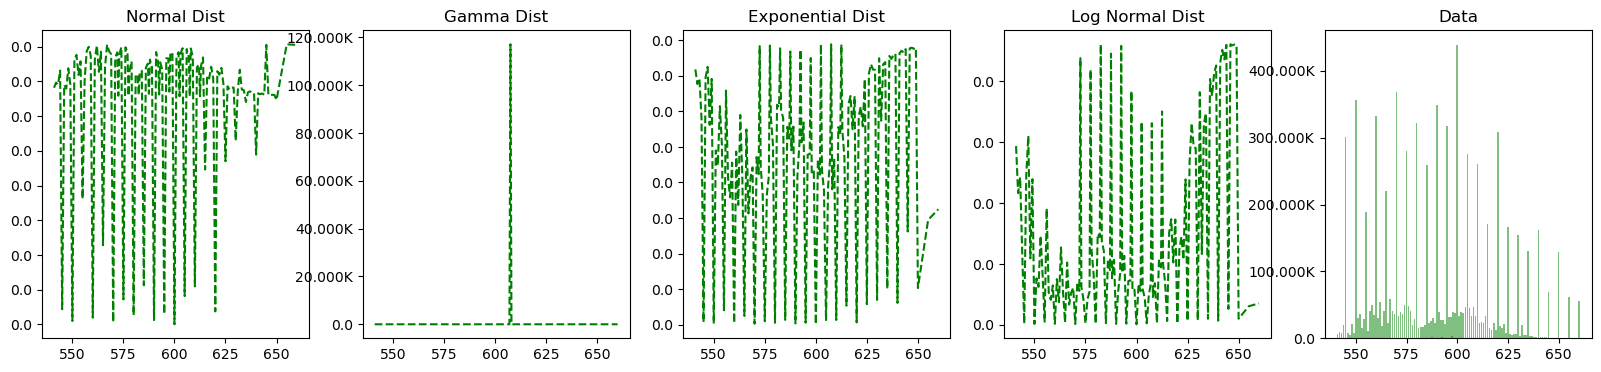

In [68]:
# Fitting The Normal Distribution to the Data
X = cp.groupby('strike').agg({'openinterest':'sum'})

# X = cp[cp.type == 'Put'].groupby('strike').agg({'charm':'sum'})

dist = stats.norm
params = dist.fit(X)
print(f"Normal Distribution Parameters: {params}")
y_fit = dist.pdf(X, *params)

# Fit Gamma Distribution
gamma_dist = stats.gamma
gamma_params = gamma_dist.fit(X)
print(f"Gamma Distribution Parameters: {gamma_params}")
y_fit_gamma = gamma_dist.pdf(X, *gamma_params)

# Fit Exponential Distribution
exp_dist = stats.expon
exp_params = exp_dist.fit(X)
print(f"Exponential Distribution Parameters: {exp_params}")
y_fit_exp = exp_dist.pdf(X, *exp_params)

# Log Normal Distribution
lognorm_dist = stats.lognorm
lognorm_params = lognorm_dist.fit(X)
print(f"Log Normal Distribution Parameters: {lognorm_params}")
y_fit_lognorm = lognorm_dist.pdf(X, *lognorm_params)


fig, ax = plt.subplots(1,5, figsize = (20,4))
    
ind = X.index
ax[0].plot(ind, y_fit, label='Normal Dist', c = 'green', linestyle = '--')
ax[0].set_title('Normal Dist')
ax[1].plot(ind, y_fit_gamma, label='Gamma Dist', c = 'green', linestyle = '--')
ax[1].set_title('Gamma Dist')
ax[2].plot(ind, y_fit_exp, label='Exponential Dist', c = 'green', linestyle = '--')
ax[2].set_title('Exponential Dist')
ax[3].plot(ind, y_fit_lognorm, label='Log Normal Dist', c = 'green', linestyle = '--')
ax[3].set_title('Log Normal Dist')
ax[4].bar(ind, X.values.flatten(), color = 'green', alpha = 0.5)
ax[4].set_title('Data')

for i in range(5):
    ax[i].set_yticklabels(human_format(x, 3) for x in ax[i].get_yticks())

show_df = pd.DataFrame({
    'strike':ind, 
    'Normal':y_fit.flatten(),
    'Gamma':y_fit_gamma.flatten(),
    'Exponential':y_fit_exp.flatten(),
    'Log Normal':y_fit_lognorm.flatten()
    }).set_index('strike').T.style.background_gradient(cmap = 'viridis', axis = 1)
show_df

In [69]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

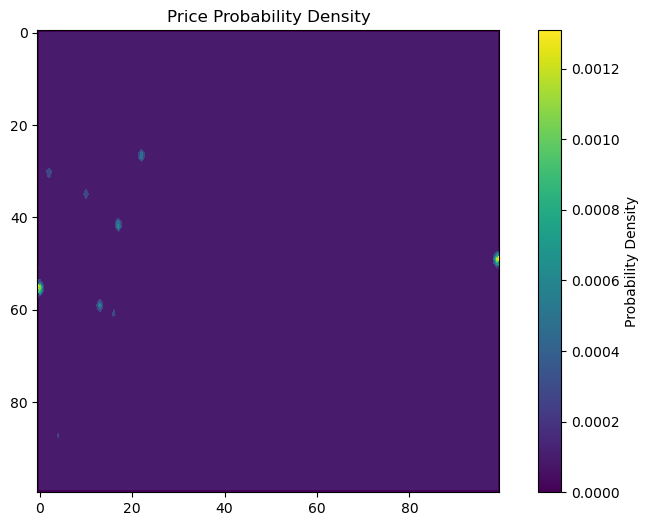

In [99]:
# Fitting The Normal Distribution to the Data
X = cp.groupby('strike').agg({'openinterest':'mean'})

xx, yy, z = kde2D(X.index, X.values.flatten(), bandwidth = 1)

fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.contourf(z, cmap='viridis')
ax.set_title('Price Probability Density')
# Add color bar
im = ax.imshow(z, cmap='viridis')
cbar = plt.colorbar(im)
cbar.set_label('Probability Density')

plt.show()




In [100]:
cp

,stock,type,strike,expiry,gatherdate,contractsymbol,stk_price,lastprice,ask,bid,...,volga,theta,rho,lam,speed,zomma,dexp,gexp,vexp,cexp
7519,SPY,Call,555.0,2025-02-10,2025-02-07 15:30:30,SPY250210C00555000,600.63,52.27,46.80,45.02,...,0.343249,-0.972185,0.059969,10.541179,-0.000009,0.006819,550.987409,1.563742e+03,-1.215616,6.559201
7520,SPY,Call,560.0,2025-02-10,2025-02-07 15:30:30,SPY250210C00560000,600.63,41.41,42.59,40.74,...,0.305539,-1.300034,0.057851,12.776107,-0.000010,0.003051,1587.175813,5.841453e+03,-4.007284,18.894273
7521,SPY,Call,565.0,2025-02-10,2025-02-07 15:30:30,SPY250210C00565000,600.63,37.01,37.48,35.10,...,0.339207,-1.202500,0.058078,14.207978,-0.000011,0.003301,105693.291777,4.525589e+05,-271.993192,1258.206659
7522,SPY,Call,570.0,2025-02-10,2025-02-07 15:30:30,SPY250210C00570000,600.63,32.10,31.94,30.79,...,0.437303,-0.926541,0.059610,16.607708,-0.000014,0.007406,274017.212384,1.330196e+06,-689.199204,3261.998306
7523,SPY,Call,575.0,2025-02-10,2025-02-07 15:30:30,SPY250210C00575000,600.63,32.54,27.51,25.18,...,0.393238,-1.094573,0.057411,15.680219,-0.000015,0.000553,366348.246564,2.314501e+06,-997.939433,4361.098313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14521,SPY,Put,640.0,2027-12-17,2025-02-07 15:30:30,SPY271217P00640000,600.63,67.28,66.63,65.03,...,8.236413,0.048518,-8.024824,-2.123143,-0.000002,-0.019318,4285.351020,-2.814320e+04,-18.790526,-20926.658146
14522,SPY,Put,645.0,2027-12-17,2025-02-07 15:30:30,SPY271217P00645000,600.63,69.12,70.51,67.31,...,6.850489,0.050761,-8.448812,-2.166802,-0.000002,-0.020214,1198.154672,-7.584753e+03,-4.528230,-5850.972977
14523,SPY,Put,650.0,2027-12-17,2025-02-07 15:30:30,SPY271217P00650000,600.63,68.99,72.82,69.07,...,6.355494,0.051442,-8.694572,-2.239919,-0.000002,-0.022219,74175.369194,-4.749748e+05,-257.811990,-362223.049621
14524,SPY,Put,655.0,2027-12-17,2025-02-07 15:30:30,SPY271217P00655000,600.63,69.58,75.52,71.60,...,5.686773,0.052427,-8.985088,-2.298481,-0.000002,-0.024176,8316.271042,-5.340631e+04,-25.962655,-40611.243492


In [95]:
# xx = The strike prices
# yy = The Open Interest values 
# z = The probability density function P(xx)
xx.shape, yy.shape, z.shape

((100, 100), (100, 100), (100, 100))

# KDE 

$$


p(x)= \frac{1}{m} \sum^m_{i = 1} \frac{1}{h^n} K (\frac{x^i - x}{h})

$$

In [ ]:
# Only keep Numerical Columns 
j = option_chain.copy()
j.type = j.type.map({"Call":1, "Put":-1})
j['dte'] = (pd.to_datetime(j.expiry) - pd.to_datetime(j.gatherdate)).dt.days
j = j.select_dtypes(include = ['number'])

<Axes: >

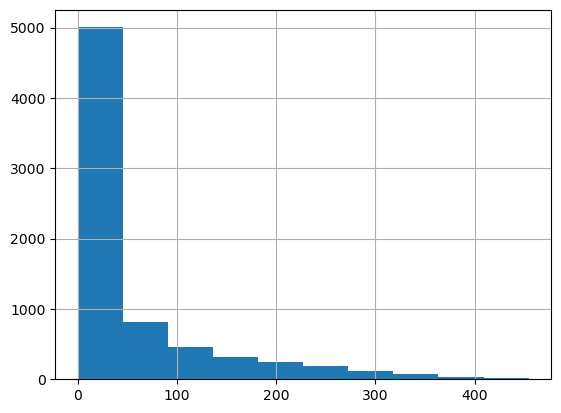

In [ ]:
x = j.lastprice

x.hist()